# Homework for Smarties 2024

## Introduction
The notation below are the same as on the slides. The topic is study of a test for the
mean function. More precisely, you have to compute a test statistic like
$$
Tnorm,N := N∥̂\hat{\mu} − \mu∥2
$$
(where $\hat{\mu}$ is some estimator of the mean function) and investigate its behavior :
under the null hypothesis $H_0 : \mu = \mu_{0}$ for some given mean function $\mu_{0}$ (e.g., the null function);
under alternatives (departures from the null).
The test size is denoted α. Using simulated data, you investigate the accuracy of the level $α$, and the
power of the test. The data have to be generated using the computer, but mimicking real data features:
the curves observed with error, on a random design set with only few points.

## Purpose
The test using $T_{norm},N$, presented in the lectures with ̂$\hat{\mu}$ the empirical mean function, is
based on asymptotic arguments and is designed for the ideal case where the curves are observed everywhere
without error. The purpose of this homework is to evaluate the consequences of applying this test with
data which are not like in the theory.

In [7]:
import numpy as np
from matplotlib import pyplot as plt

Now we generate the X(t) based on the Karhunen-Loève expansion for Brownian motion

In [8]:
def FDA_generator(N, K, J, noise_var, mu0_func=None, mu_func=None, plot=False, gamma=None):

    #Parameters
    #K = 100 #number of domain points
    #N = 100 #number of curves

    #Create a random set of domain points. These are usually fixed for all the curves
    t = np.random.uniform(0, 1, K)

    #KL brownian motion
    #J = 10 #KL truncation at J terms

    #create lmda (eigenvalues) phi(t) (eigenfunctions)
    lmda = [1 / ((j-0.5)**2 * np.pi**2) for j in range(1,J+1)]
    phi = [np.sqrt(2)*np.sin(j*np.pi*t) for j in range(1,J+1)]


    #epsilon noise variance
    #noise_var = [0, 0.5, 1.0, 2.0]

    # Define a mean function mu(t) (for example, a simple linear mean function)
    if mu_func == "sin":
        mu = np.sin(2 * np.pi * t)  # Example mean function
    elif mu_func == "custom":
        if mu0_func == "sin":
            mu_0 = np.sin(2 * np.pi * t)
        else:
            mu_0 = np.zeros(K)
        mu_star = np.cos(2 * np.pi * t)
        mu = gamma * mu_0 + (1 - gamma) * mu_star
    else:
        mu = np.zeros(K)

    for var in noise_var:
        X = np.zeros((N, K))  # Reset curves for each noise variance
        Y = np.zeros((N,K))
        t_sorted = np.zeros((N, K))
        X_sorted = np.zeros((N, K))
        Y_sorted = np.zeros((N, K))
        # Adjust figure size to make the plot wider
        if plot:
            plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
        for i in range(N):
            X[i] = mu.copy()  # Set the mean function as the initial value of the curve
            for j in range(J):
                X[i] += np.random.normal(0, np.sqrt(lmda[j]), K) * phi[j] # xi * phi where xi ~ N(0, lmda)

            #Add noise
            Y[i] = X[i].copy()
            Y[i] += np.random.normal(0, np.sqrt(var), K) #epsilon noise

            # Sort the domain points t and corresponding X and Y values
            sorted_indices = np.argsort(t)  # Get sorted indices of t
            t_sorted[i] = t[sorted_indices]    # Sorted domain points
            X_sorted[i] = X[i][sorted_indices] # Corresponding X values sorted by t
            Y_sorted[i] = Y[i][sorted_indices] # Corresponding Y values sorted by t

            
            
            #Plot
            if plot:
                if (i+1) % 30 != 0:  # Limit the number of curves to plot for better visualization
                    continue
                plt.plot(t_sorted[i], X_sorted[i], linewidth=0.5, label=f"X{i+1}")
                plt.scatter(t_sorted[i], Y_sorted[i], s=10, marker='o', label=f"Y{i+1}")

        #Store the t_sorted, X_sorted and Y_sorted values for each noise variance
        np.savetxt(f"t_sorted_{var}.csv", t_sorted, delimiter=",")
        np.savetxt(f"X_sorted_{var}.csv", X_sorted, delimiter=",")
        np.savetxt(f"Y_sorted_{var}.csv", Y_sorted, delimiter=",")

    
        # Plot
        if plot:
            plt.xlabel("t")
            plt.ylabel("X(t)")
            plt.title(f"Effect of Noise Variance={var} on X(t)")
            plt.legend()
            plt.show()



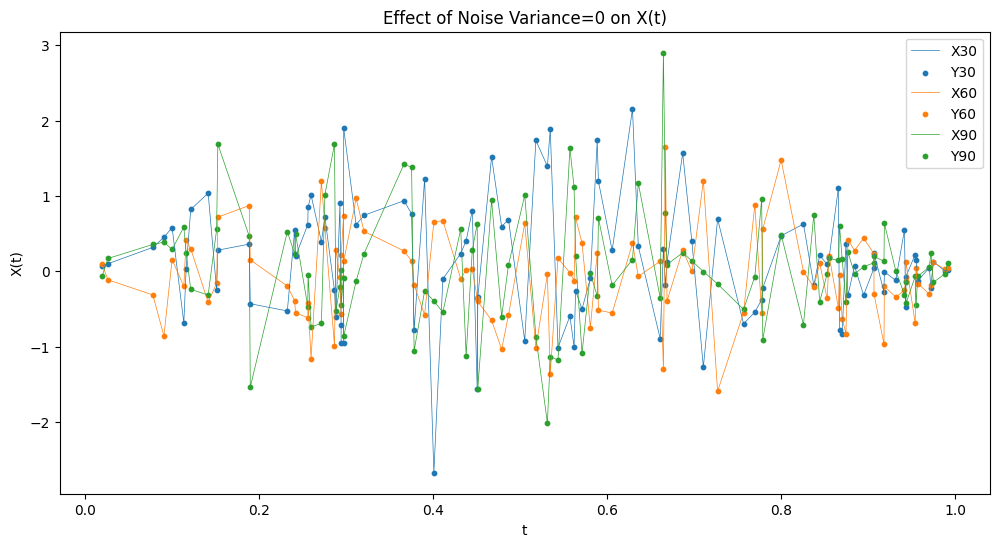

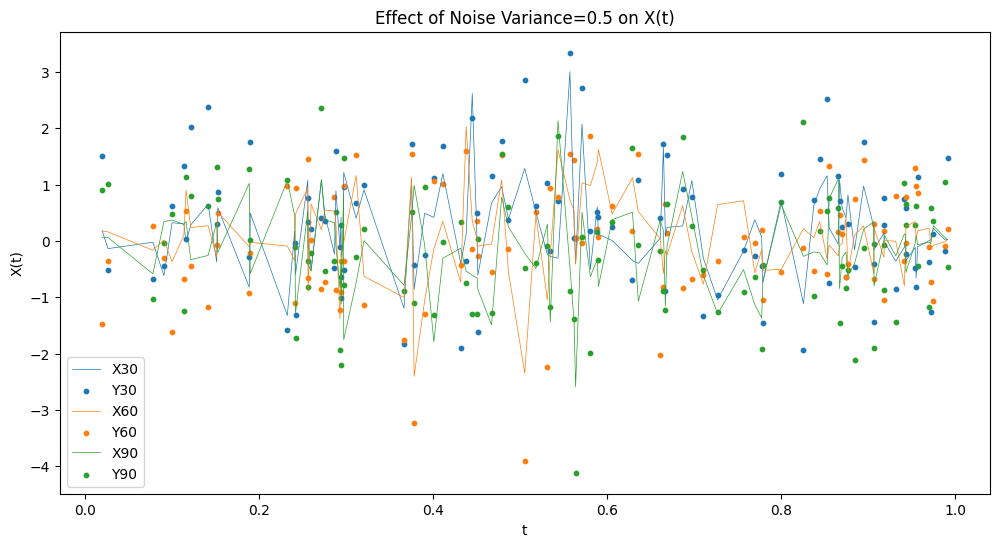

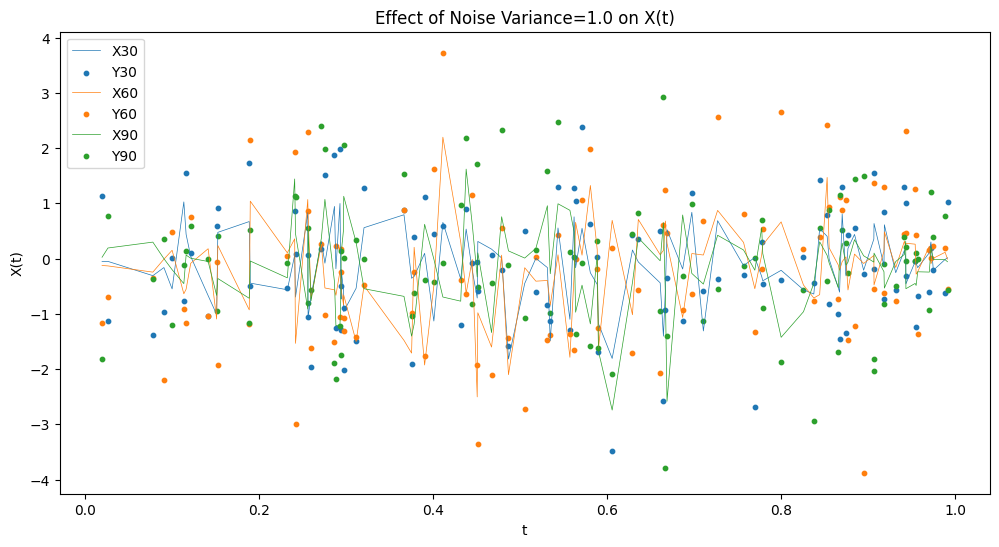

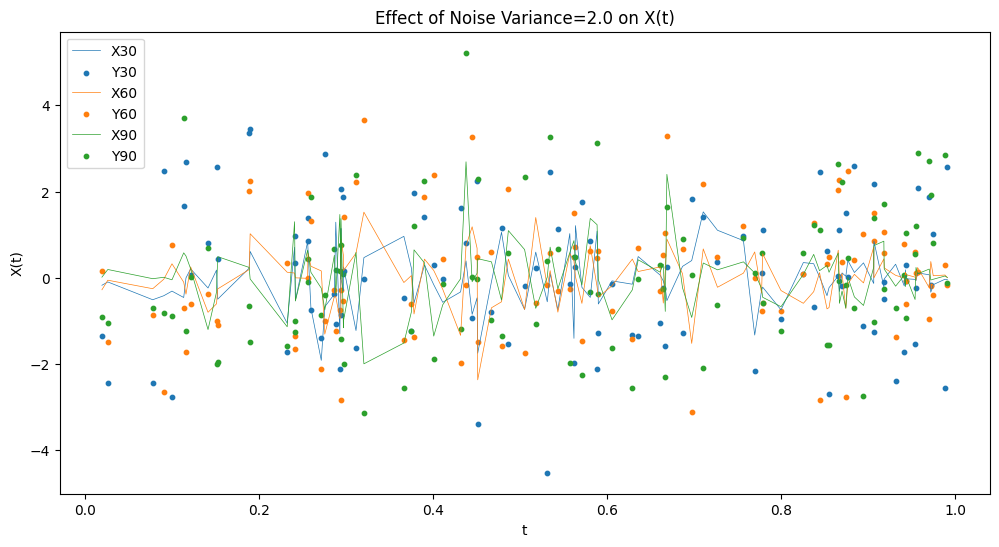

In [9]:
FDA_generator(100, 100, 10, [0, 0.5, 1.0, 2.0], plot=True)

## Curves reconstruction


In theory, the curves have to be reconstructed for each $t$ ∈ [0,1], and next
averaged to get the mean function estimator. In practice, is not possible to reconstruct the curves $X_i$ in
any point $t$, a refined grid of points will be used instead.

Consider some (large) L, and an equidistant grid of L+ 1 points on [0,1], that is tl = l/L, 0 ≤l ≤L.
For each i, you have to compute $\hat{X_i(t_l)}$ that are estimates of $X_i(t_l)$, for all $t_0,t_1,\dots,t_L$. Two types
of estimates will be asked :

– estimate the $X_i(t_l)$’s by linearly interpolating the $Y_{ik}$;

– estimate the $X_i(t_l)$’s by smoothing, either kernel smoothing (Nadaraya-Watson) or splines

In [10]:
#TODO: Implement Nadaraya-Watson Kernel Regression

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

def curve_approximation(interpolation_kind, noise_var, L, N, plot=False):
    # construct the tl grid
    #L = 200

    for var in noise_var:
        t_sorted = np.loadtxt(f"t_sorted_{var}.csv", delimiter=",")
        X_sorted = np.loadtxt(f"X_sorted_{var}.csv", delimiter=",")
        Y_sorted = np.loadtxt(f"Y_sorted_{var}.csv", delimiter=",")
        X_hat_tl = np.zeros((N, L))
        if plot:
            plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
        for i in range(N):
            t_min = np.min(t_sorted[i])
            t_max = np.max(t_sorted[i])

            # Ensure tl is within the range of t_sorted[i]
            tl = np.linspace(t_min, t_max, L)

            if interpolation_kind != "CubicSpline":
                interpolator = interp1d(t_sorted[i], Y_sorted[i], kind=interpolation_kind)
            else:
                interpolator = CubicSpline(t_sorted[i], Y_sorted[i], bc_type='natural')  # 'natural' for natural boundary conditions
            X_hat_tl[i] = interpolator(tl)

            #Plot
            if plot:
                if (i+1) % 90 == 0:
                    plt.plot(t_sorted[i], X_sorted[i], linestyle='--', linewidth=0.5, label=f"X{i+1}")
                    plt.scatter(t_sorted[i], Y_sorted[i], s=10, marker='o', label=f"Y{i+1}")
                    plt.plot(tl, X_hat_tl[i], linewidth=0.5, label=f"X_hat{i+1}")

        #Store the X_hat_tl values for each noise variance
        np.savetxt(f"X_hat_tl_{var}_{interpolation_kind}.csv", X_hat_tl, delimiter=",")
        
        if plot:
            plt.xlabel("t")
            plt.ylabel("X(t)")
            plt.title(f"{interpolation_kind} interpolation with Noise Variance={var} on X(t)")
            plt.legend()
            

    

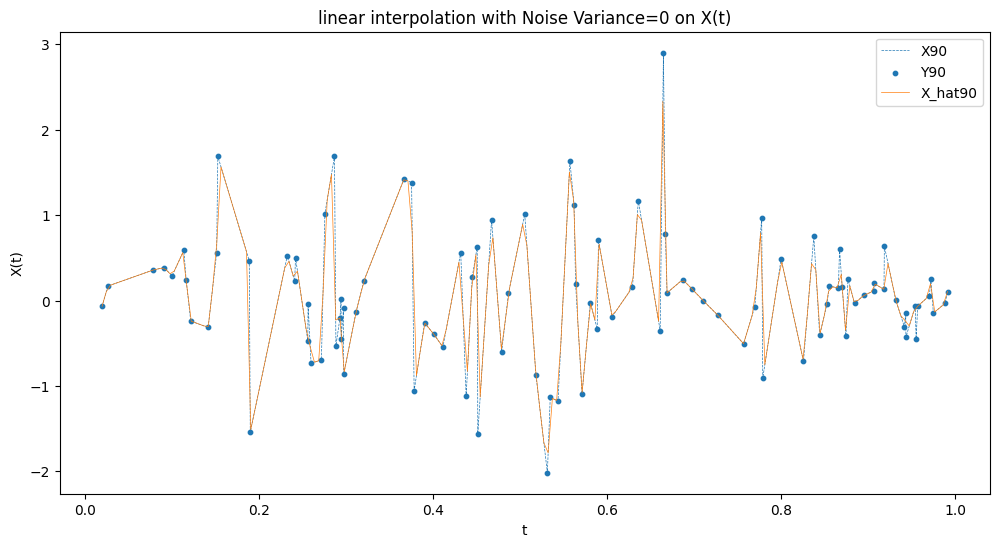

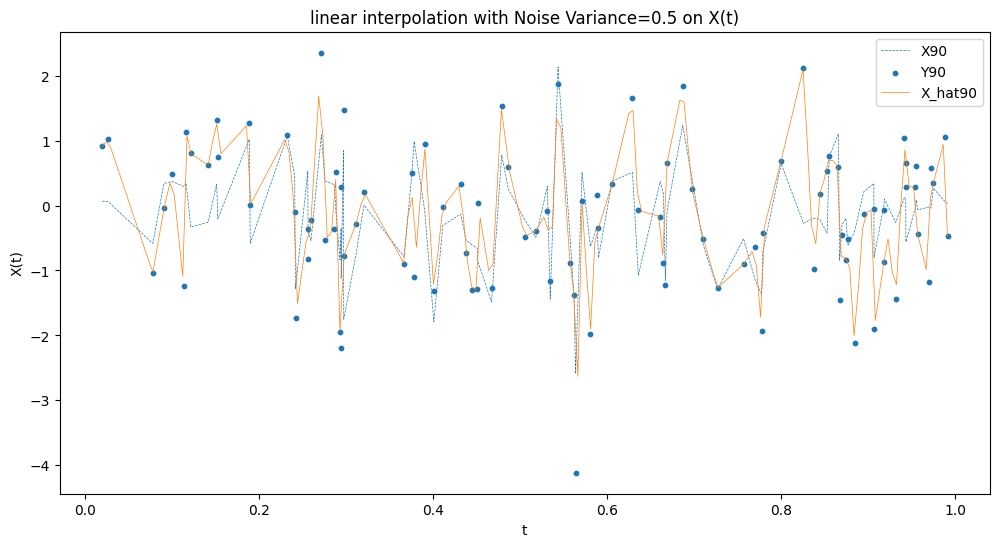

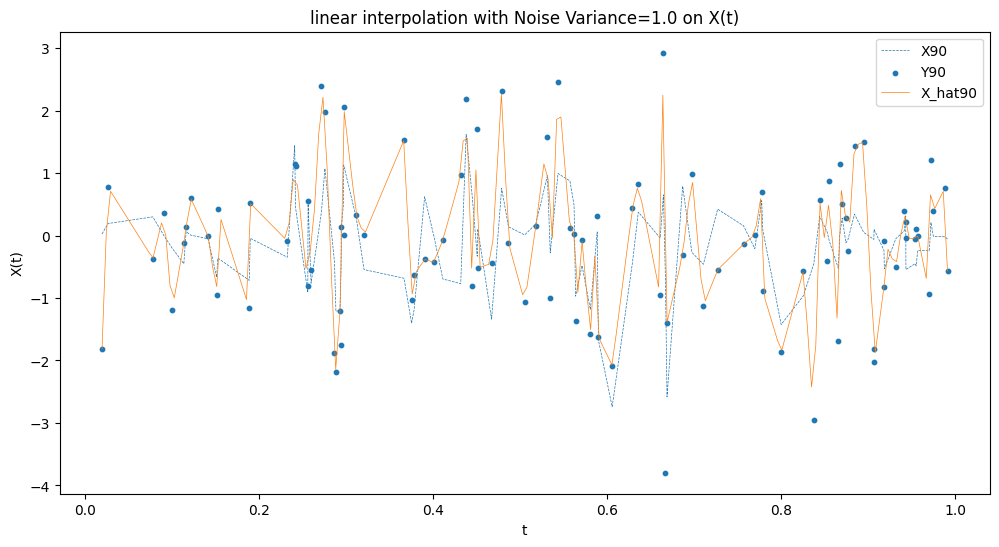

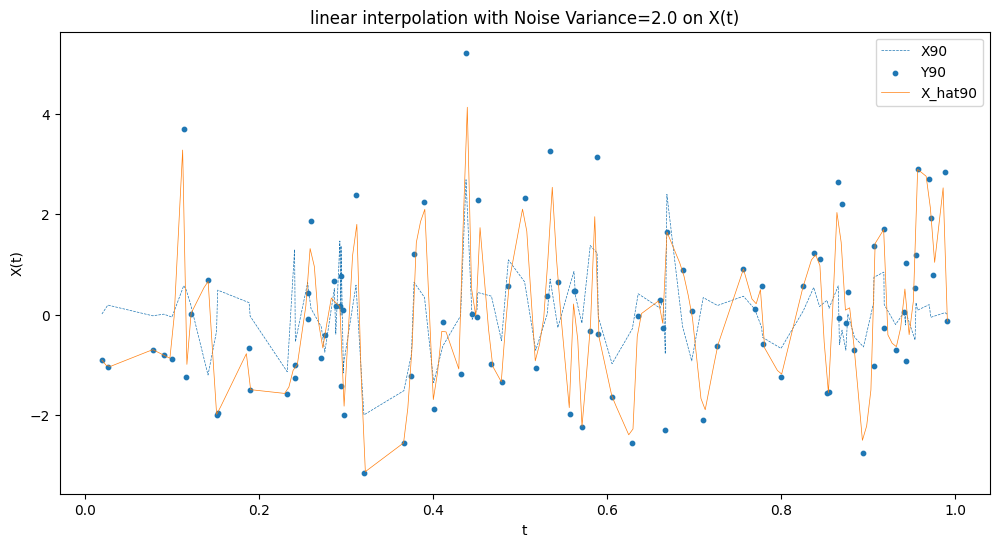

In [11]:
curve_approximation("linear", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

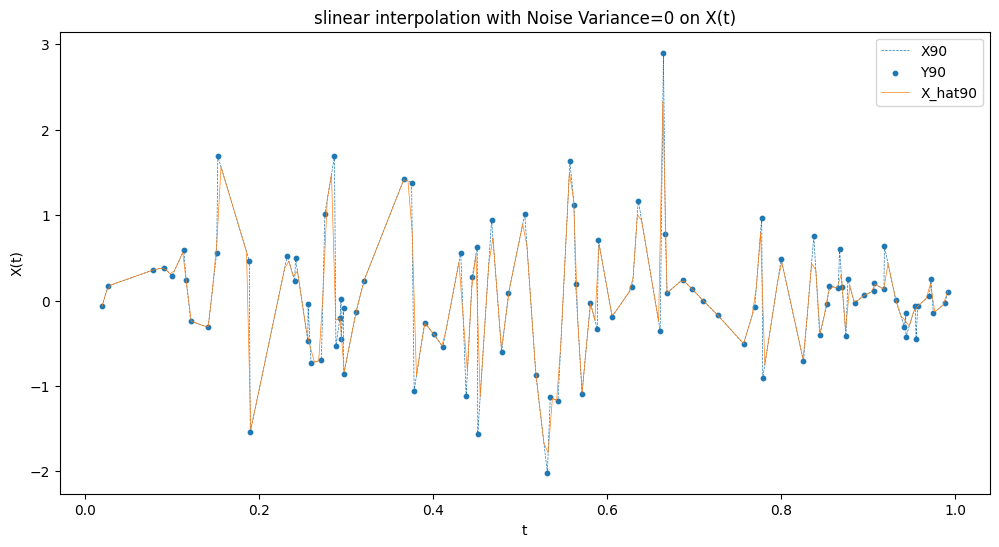

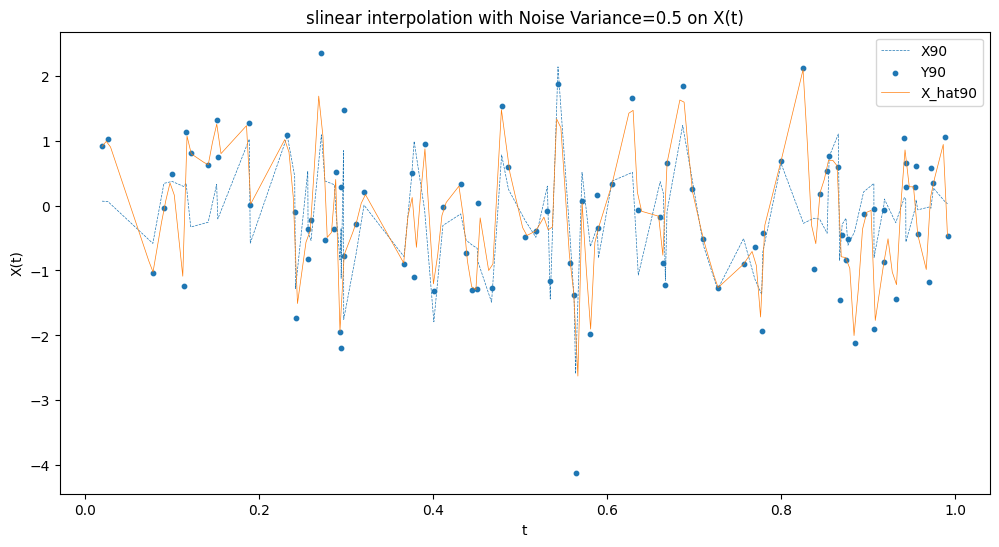

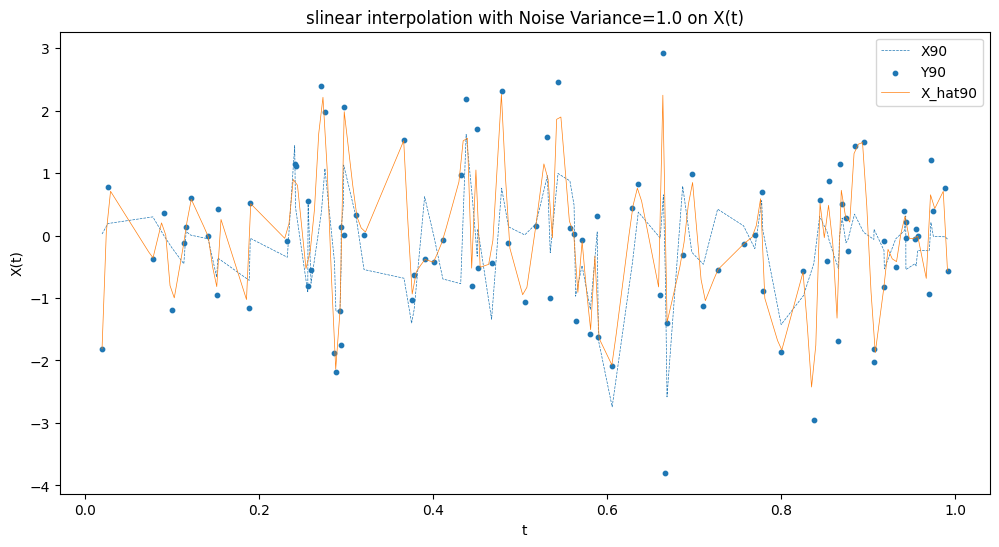

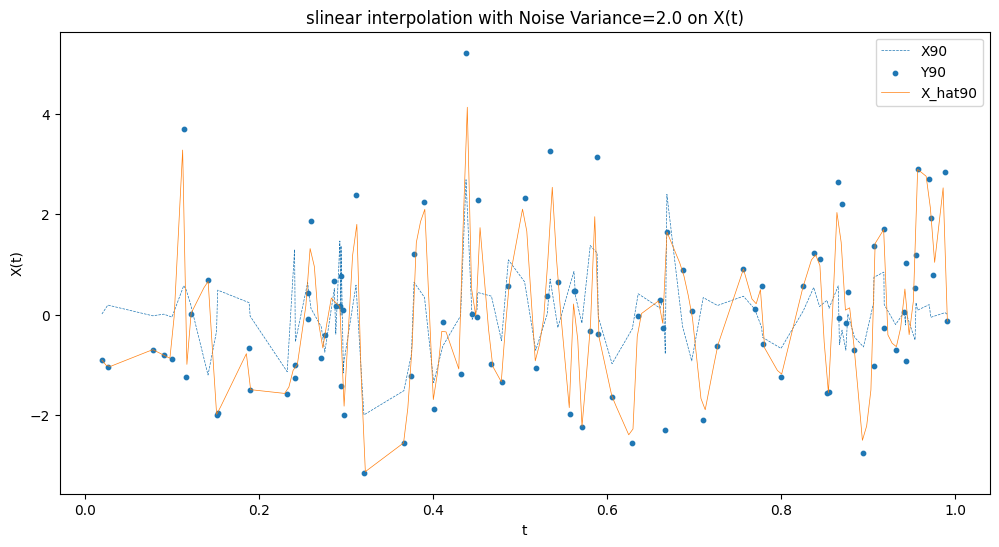

In [12]:
curve_approximation("slinear", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

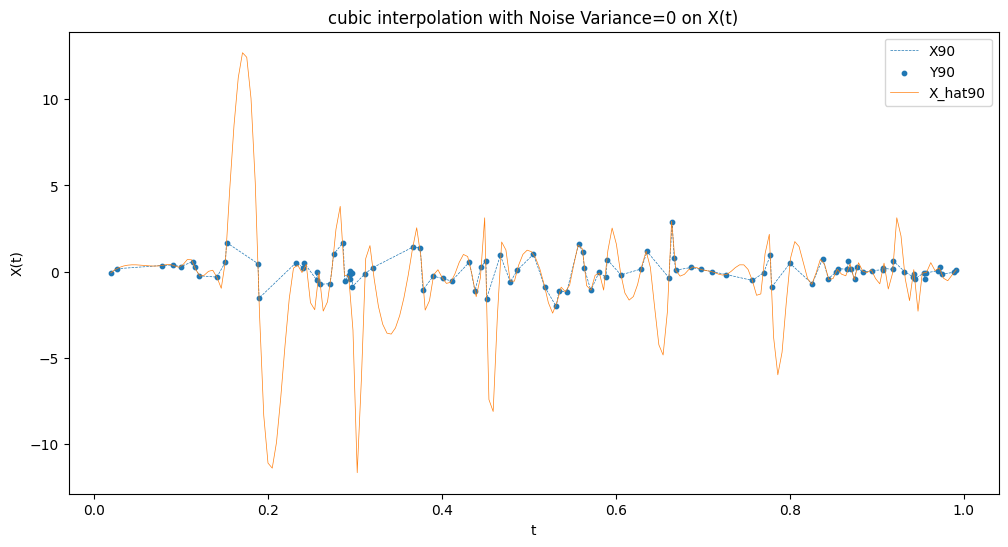

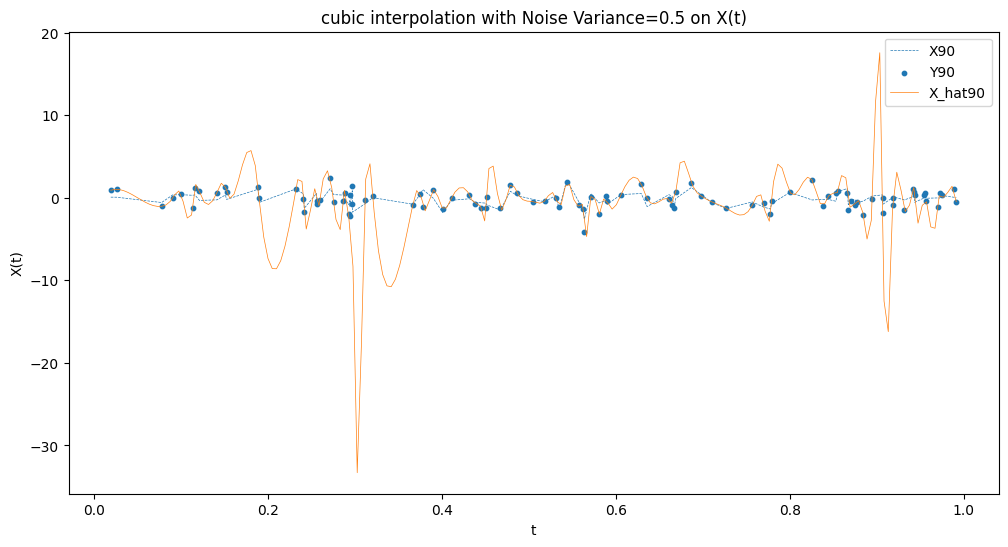

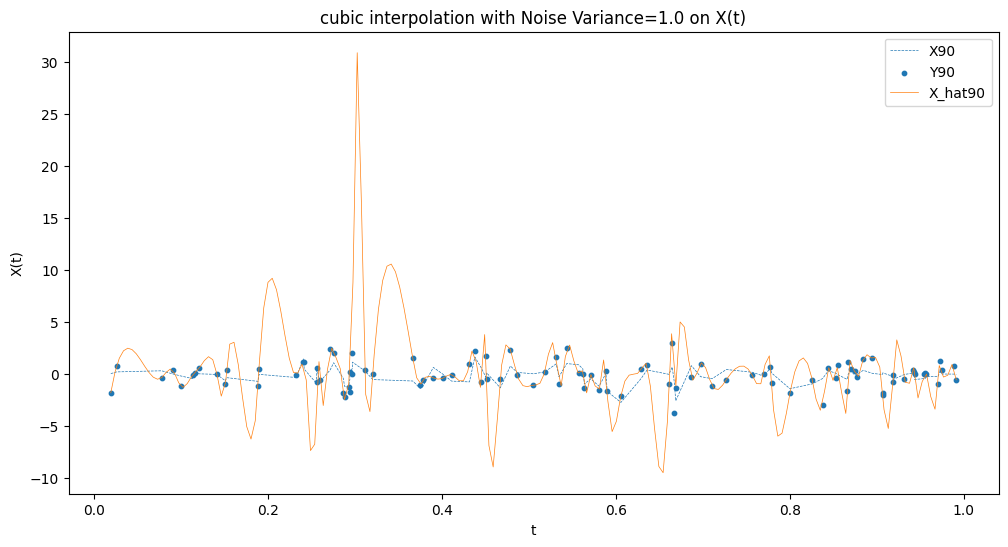

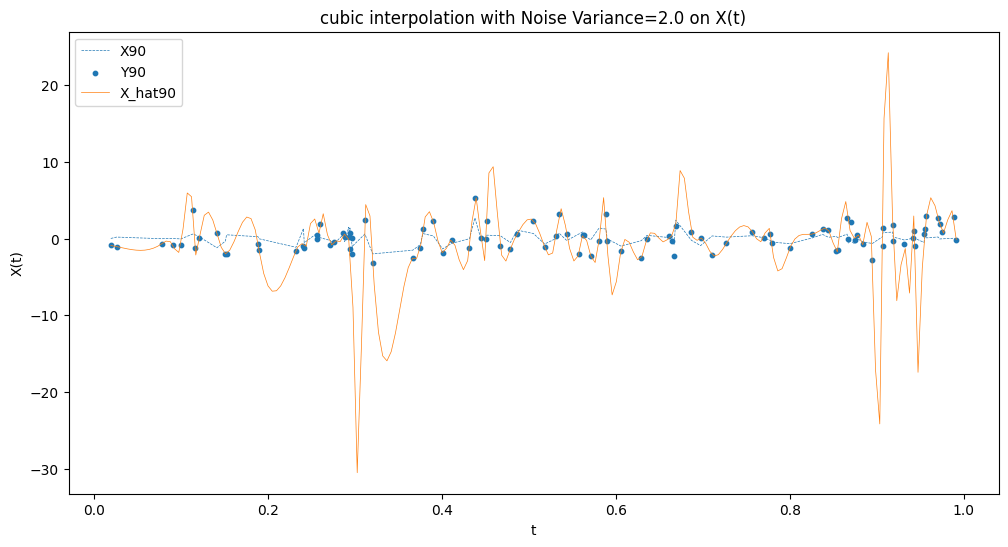

In [13]:
curve_approximation("cubic", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

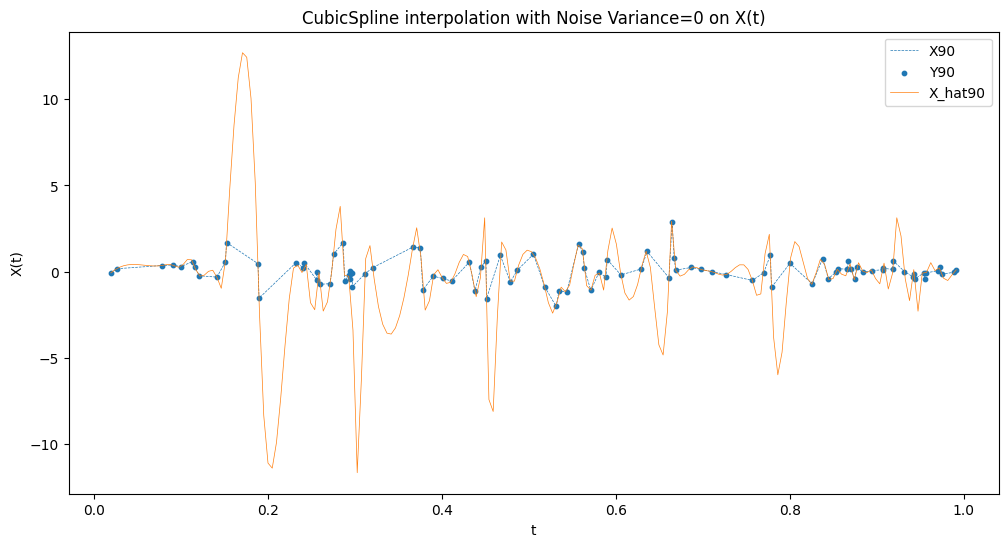

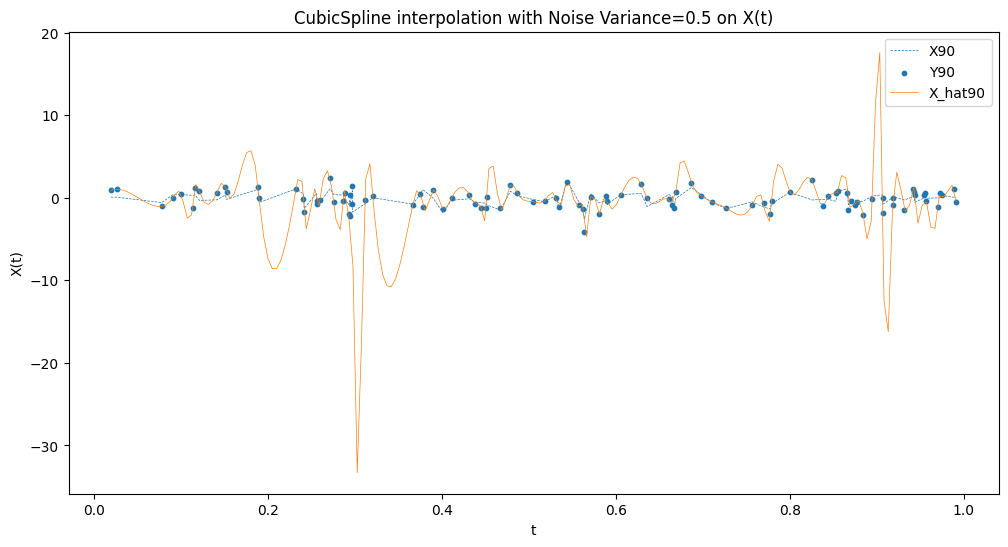

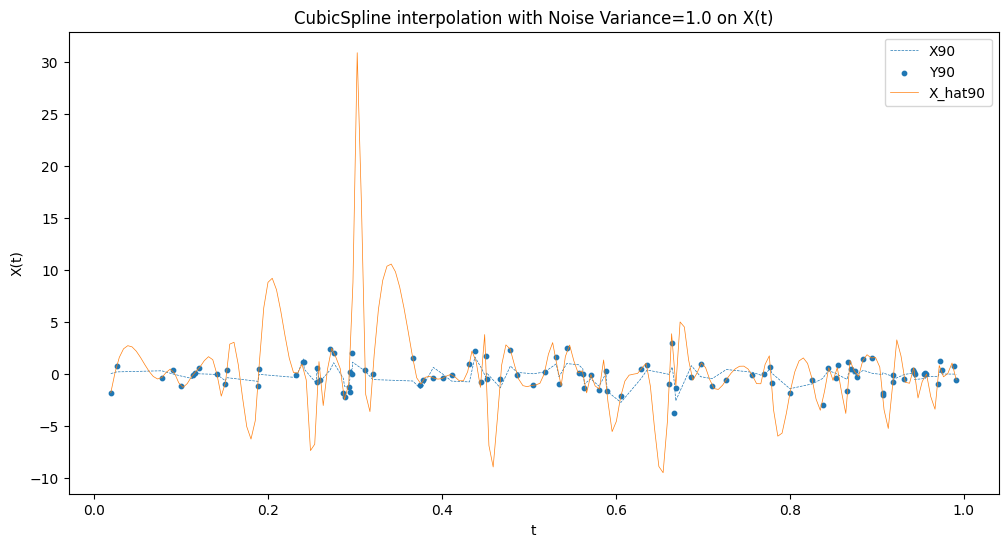

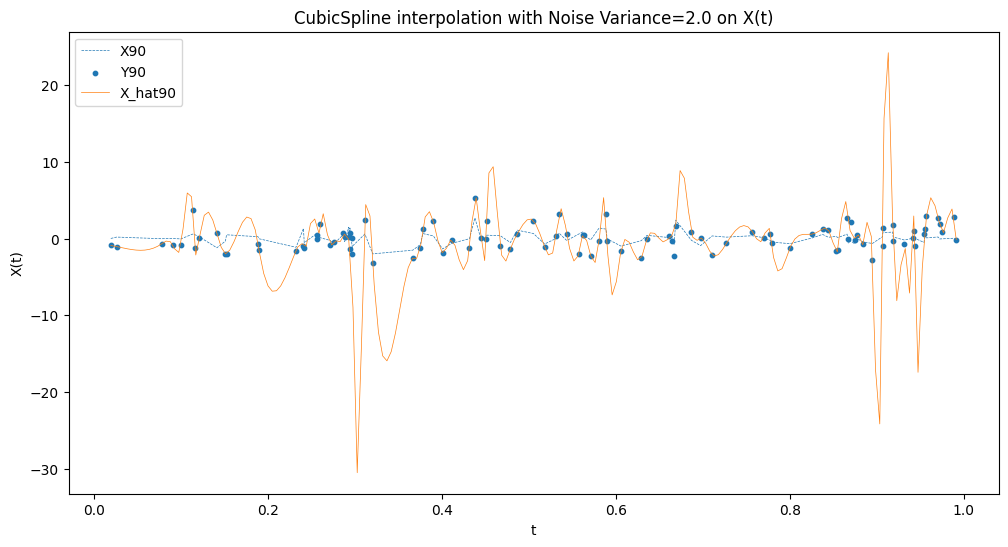

In [14]:
curve_approximation("CubicSpline", [0, 0.5, 1.0, 2.0], 200, 100, plot=True)

### Conclusion for Curve Estimation
From the results above, it is clearly seen that curve estimation techniques using interpolation (linear, cubic, spline etc.) do not approximate the $X$ values correctly. Some other methods need to employed to do such approximations.

## Computing the test statistic

### Estimating the empirical mean of $\hat{X_i}$
The mean 
$$
\hat{\mu}(t_l) = \frac{1}{N}\sum_{i=1}^N \hat{X}(t_l) , l=0,1,\dots,L
$$
We consider the cubic spline interpolated $\hat{X}(t_l)$ for estimating the empirical mean.

$T_{norm}$ is approximated using the trapezoidal rule.

In [17]:
from scipy.integrate import trapezoid
#calculate mu_hat and mu_0
def calculate_means_Tstats(L, N, noise_var, interpolation_kind=None, mu0_func=None, plot=False):
    #expected mu function
    t = np.linspace(0, 1, L)
    if mu0_func == "sin":
        mu_0 = np.sin(2 * np.pi * t)  # Example mean function
    else:
        mu_0 = np.zeros(L)
    if plot:
        plt.figure(figsize=(12, 6))  # Width = 12, Height = 6 (you can adjust these values)
    #load the X_hat_tl values for each noise variance
    for var in noise_var:
        X_hat_tl = np.loadtxt(f"X_hat_tl_{var}_{interpolation_kind}.csv", delimiter=",")
        mu_hat = np.mean(X_hat_tl, axis=0)
        if plot:
            plt.plot(t, mu_hat, label=f"mu_hat_{var}")
        #Compute the Tstatistic
        difference = (mu_hat - mu_0) ** 2
        Tnorm_N = float(trapezoid(difference, t) * N)
        if plot:   
            print(f"Tnorm_N for noise variance={var} is {Tnorm_N}")
        else:
            return Tnorm_N
    
    if plot:
        plt.plot(t, mu_0, label="Expected mean function", linestyle='--', linewidth=2, color='black')
        plt.xlabel("t")
        plt.ylabel("mu(t)")
        plt.title(f"Mean Function Estimation using {interpolation_kind} Interpolation")
        plt.legend()
        plt.show()


Tnorm_N for noise variance=0 is 3.2157414668382795
Tnorm_N for noise variance=0.5 is 6.763608974089397
Tnorm_N for noise variance=1.0 is 16.949528739041323
Tnorm_N for noise variance=2.0 is 27.687724950456506


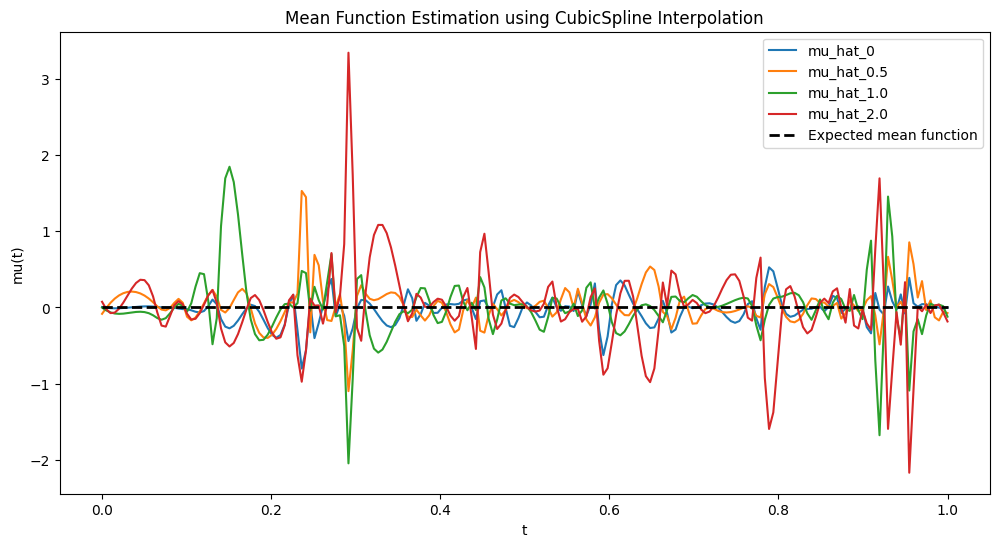

In [18]:
calculate_means_Tstats(200, 100,  [0, 0.5, 1.0, 2.0], "CubicSpline", mu0_func=None, plot=True)


### Conclusion
The estimated mean values of the curves interpolated using cubic spline interpolation, based on the different variances  in the noise, show that they are quite far away from the expected mean.

The $T_{norm,N}$ values show interesting results. For noise variance = 0, we see that the $T_{norm,N} \approx 36$ but it reduces on adding a noise with variance $0.5$ to $T_{norm,N} \approx 15$. The added noise somehow is reducing the signal to nose ratio to get a better $T_{norm,N}$ value. The other 2 noise added data show poor $T_{norm,N}$ values.  
These values need to be analysed over several runs to see whether the T-scores are consistent and compared to the ideal T-score. This is done in the next section.

## Compute critical values of the test

Here we are computing the $T_{norm,N}$ values using a Monte-Carlo simulation of $R = 1000$ iterations. The T-test value i.e $T_{norm,N} = N|\hat{\mu}-\mu|^{2}$ for the difference between the empirical mean function of $X_i$ and the expected mean function of X, is given by
$$
T_{norm,N} = N|\hat{\mu}-\mu|^{2} = \sum_{J \geq 1} \lambda{j}\Z_{j}
$$
where, $\lambda_{j}$ is the eigenvalues of the covariance operator of $X$ and $Z$ is a random vector that follows the chi-squared $\chi^2$ distribution. The $\chi^2$ random vector contains $M = 250$ i.i.ds with $N = 100$ degrees of freedom. The sum of the $Z$ over $j$ is another $\chi^2$ distribution.  
We then compute the quantile value at the given $\alpha = 0.05$

In [19]:
 #create lmda (eigenvalues) phi(t) (eigenfunctions)
N = 100 #number of curves
M = 250 #KL truncation at M terms
alpha = 0.05
R = 1000 #number of simulations

lmda = np.array([1 / ((j-0.5)**2 * np.pi**2) for j in range(1,M+1)])

Tnorm_M = []
for _ in range(R):
    #create Z random variable from chi-squared distribution
    Z = np.random.chisquare(N, M)
    #Compute the Tstatistic
    Tnorm_M.append(np.sum(lmda*Z)) 
    
Tnorm_M = np.array(Tnorm_M)
#calculate the quantiles
quantile_Tnorm = np.quantile(Tnorm_M, 1-alpha)

print(f"Quantile for alpha=1-{alpha} is {quantile_Tnorm}")

Quantile for alpha=1-0.05 is 59.38101277667552


### Conclusion
We have modeled the $T_{norm,N}$ as a weighted sum of a chi-squared random variable. 

The quantile of $1-\alpha$ where $\alpha = 0.05$ tell us that $95\%$ of the time the $T_{norm,N}$ value will be below this quantile value.

## Simulation

In [20]:
def indicator_function(Tnorm_N, quantile_Tnorm):
    if Tnorm_N >= quantile_Tnorm:
        return 1 #rejected
    else:
        return 0 #not rejected
    
def simulate(R, N, L, K, J, noise_var, gamma, quantile_Tnorm, mu0_func=None, mu_func=None):
    indicator_list = []
   
    for _ in range(R):
         #Generate the curves
        FDA_generator(N, K, J, noise_var, mu0_func=mu0_func, mu_func=mu_func, plot=False, gamma=gamma)
        #Approximate the curves
        curve_approximation("CubicSpline", noise_var, L, N, plot=False)
        #Calculate the means and Tstats
        Tnorm_N = calculate_means_Tstats(L, N, noise_var, "CubicSpline", mu0_func=mu0_func, plot=False)
        #Compute the indicator function
        indicator_list.append(indicator_function(Tnorm_N, quantile_Tnorm))
    #Compute mean of the indicator function
    mean_indicator = np.mean(indicator_list)
    return mean_indicator

    

### Null hypothesis
Here we provide the rejection probability of the Null hypothesis. $H_0:\mu_0 = \mu$.

In [21]:
rejection_probability = simulate(R=200, N=100, L=200, K=10, J=300, noise_var=[0,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func=None)
print(f"Rejection probability is {rejection_probability}")

Rejection probability is 0.125


In [ ]:
rejection_probability = simulate(R=200, N=100, L=200, K=100, J=300, noise_var=[0,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func=None)
print(f"Rejection probability is {rejection_probability}")

Rejection probability is 0.27


#### Remark 1:
Here we tried to simulate the ideal case scenario with no noise, $\mu_0 = 0$ and $\mu = 0$. We get a rejection probability of the null hypothesis as $27\%$. Here we can see clearly that the cubic spline interpolation is not good at predicting the missing points in FDA data. This is how often the null hypothesis $H_0 : \mu_0 = \mu$ is rejected.

In [22]:
rejection_probability = simulate(R=200, N=100, L=200, K=10, J=300, noise_var=[0.5,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func=None)
print(f"Rejection probability is {rejection_probability}")

Rejection probability is 0.125


In [ ]:
rejection_probability = simulate(R=200, N=100, L=200, K=100, J=300, noise_var=[0.5,], gamma=0, quantile_Tnorm=quantile_Tnorm, mu0_func=None, mu_func=None)
print(f"Rejection probability is {rejection_probability}")

Rejection probability is 0.41


#### Remark 2:
With the scenario $\mu_0 = 0$ and $\mu = 0$ and adding some noise variance ($0.5$), we see that the rejection probability of the null hypothesis jumps to $41\%$.

### Alternate hypothesis